In [1]:
import matplotlib.mlab as mlab
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:,.4f}'.format

sns.set_context('paper')
sns.color_palette('muted')
sns.set_style('whitegrid')
%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Import data

In [2]:
# Import track-level API data
trk = pd.read_json('../data/track_df.json')

# Make explicit column headers to avoid confusion when we merge with playlist track
trk = trk.rename(columns = {'name':'trk_name', 'id':'trk_id', 
                            'playlist_id':'pl_id', 'artist':'art_name', 
                            'popularity':'trk_popularity', 'added_at':'trk_added_at',
                           'duration':'trk_duration'})

print(trk.dtypes)
trk.head(10)

trk_added_at      datetime64[ns]
art_name                  object
trk_duration             float64
explicit                 float64
trk_id                    object
trk_name                  object
pl_id                     object
trk_popularity           float64
dtype: object


,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity
0,2013-09-30 16:12:24,Allgott & Villgott,"119,907.0000",0.0000,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0000
1,2013-10-05 15:22:13,Allgott & Villgott,"67,918.0000",0.0000,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0000
10,2014-07-16 13:50:24,J Boog,"217,270.0000",0.0000,4RjHalDdUreXDJSJLo44lK,Sunshine Girl,35XFuuqgCvTYQARix7CFpm,53.0000
100,2014-07-06 09:12:01,Brennan Heart,"222,919.0000",0.0000,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0000
1000,2012-06-29 11:53:52,Johnny Ray,"153,375.0000",0.0000,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0000
10000,2016-10-19 08:47:35,Hurula,"220,929.0000",0.0000,69UN0GDw1dvmE3YxGJ0HUy,Helvete här,5xL1c6RCMhVDTVLZUsY5SR,41.0000
100000,2014-08-04 16:09:48,Becky G,"206,166.0000",0.0000,3DmW6y7wTEYHJZlLo1r6XJ,Shower,5BASWniNjjZADnD9i96L45,70.0000
100001,2013-08-03 17:10:52,Elton John,"290,680.0000",0.0000,1DqMnZpdOXy4mjmsXnFv2t,Circle Of Life,6uSxJmUwlS3RqjGEA0TRq8,4.0000
100002,2013-09-10 14:11:36,Daniel Adams-Ray,"231,013.0000",0.0000,1qIAqSCPcRkkNU8dj5pIOC,Gubben i lådan,6Y81KUgVKTPUYHO05A2Sqr,53.0000
100003,2017-08-20 10:53:49,Tony! Toni! Toné!,"241,466.0000",0.0000,0HsTJZWuj9vY7Ns0If1ARm,If I Had No Loot,0mEm0SZ7WsnI3w8ycnO6ue,37.0000


In [3]:
# Import playlist-level API data
pl = pd.read_json('../data/plist_df.json')

# Make explicit column headers to avoid confusion when we merge with playlist track
pl = pl.rename(columns = {'name':'pl_name', 'id':'pl_id', 'followers':'pl_followers', 
                          'num_tracks':'pl_num_trks', 'user':'pl_owner',
                         'desc':'pl_desc'})

print(pl.dtypes)
pl.head(10)

collab             bool
pl_desc          object
pl_followers    float64
pl_id            object
pl_name          object
pl_num_trks       int64
pl_owner         object
dtype: object


,collab,pl_desc,pl_followers,pl_id,pl_name,pl_num_trks,pl_owner
0,False,None,2.0000,3ftsSOkyCsILZeAZYQr2jH,Allgott o villgott,6,ellenholstad
1,False,None,0.0000,27NLrsj0rlUi9S9Buj7NEl,Emelie och Nelli,9,ellenholstad
10,False,None,9.0000,2DVuNt17JxlUUwP8VbjYMZ,Dame mas chocolinas,54,maka_97
100,False,None,22.0000,07nCTAAPUQl3O9835StlnA,Miami Morty 💎🍭💸💘,46,thefamousnobody
1000,False,None,0.0000,2nLFBeJkALxMcmYHqOnBAE,Michael Bublé – Call Me Irresponsible,13,vimmel76
1001,False,None,4.0000,3kCN0aICbIUs7RjgVK00s6,Mornings with Angel,58,1177637361
1002,False,None,0.0000,6xIePScn5oFe1XC1XZMRpm,One Direction — Olivia,3,blake.binns
1003,False,None,0.0000,7H9SO2xfI394iVQLNXvO63,svensksommar,79,vimmel76
1004,False,None,0.0000,2wHiKFc66l2W05tO2iBNMe,rosario,40,vimmel76
1005,False,None,0.0000,1HA2U1AKqHBjDT7DcCHlqR,rosa passos,115,vimmel76


In [5]:
# Import playlist-level API data
art = pd.read_json('../data/artist_genres_df.json')

# Make explicit column headers to avoid confusion when we merge with playlist track
art = art.rename(columns = {'artist':'art_name', 'artist_followers':'art_followers', 
                          'artist_genre':'art_genre', 'artist_pop':'art_pop',
                         'artist_id':'art_id'})

print(art.dtypes)
art.head(10)

art_name          object
art_followers    float64
art_genre         object
art_id            object
art_pop          float64
dtype: object


,art_name,art_followers,art_genre,art_id,art_pop
0,Allgott & Villgott,76.0000,None,5psFWO0ApFkCgzjuToEHx3,8.0000
1,J Boog,"103,793.0000",[polynesian pop],7oEWmZ9dKlAVxTgmjUbYr4,63.0000
10,Trouble Maker,"57,509.0000","[dance pop, k-pop]",0ztjVBmFk6OuHq6XBBwMI9,48.0000
100,Whigfield,"14,986.0000","[bubblegum dance, dance pop, eurodance, europo...",0lHoDF96DNKSIcIpcOfMnq,56.0000
100000,Los Violadores,"15,328.0000","[argentine rock, latin alternative, latin meta...",4EkrhlCS2DbFxvC3Uhq6p2,45.0000
100001,Catupecu Machu,"117,138.0000","[argentine rock, cumbia pop, latin alternative...",059ysTnWcrm4yFwTr0NDjc,60.0000
100002,Divididos,"179,105.0000","[argentine rock, cumbia pop, latin alternative...",6ZIgPKHzpcswB8zh7sRIhx,65.0000
100003,Fidel Nadal,"78,459.0000","[argentine reggae, argentine rock, deep latin ...",7l2wptrNdI4wEHxTlWa6SS,55.0000
100004,Nonpalidece,"108,970.0000","[argentine reggae, argentine rock, cumbia pop,...",0W1EfnztQTHuv03MuMzWPe,63.0000
100005,Eterna Inocencia,"13,291.0000",[argentine rock],5O8lCdBWT1JlDufwVywp01,46.0000


# Data wrangling - Spotify set

Before we import any external data sets, let's add some relevant data features that are inherit in the trk and pl dataframes:

# Master Dataset Build

In [6]:
# First, merge the two source datasets (one from track data API, one from playlist data API)
df_temp = pd.merge(left = trk, right = pl, on = 'pl_id', how = 'left').dropna(subset = ['pl_followers'])
print("Master DF has total of {0} rows (including zero followers)".format(df_temp.shape[0]))

# Cut out the zero- and one- follower playlists
# Cutting one-follower playlists because it's likely just an individual following their own list
df_temp = df_temp[df_temp['pl_followers'] > 1]
print("Master DF has total of {0} rows (after removing zero followers) \n".format(df_temp.shape[0]))

# Now, fold in artist genre information
df_trk = pd.merge(left = df_temp, right = art, how = 'left')


print(df_trk.dtypes)
df_trk.head(10)

Master DF has total of 367916 rows (including zero followers)
Master DF has total of 210802 rows (after removing zero followers) 

trk_added_at      datetime64[ns]
art_name                  object
trk_duration             float64
explicit                 float64
trk_id                    object
trk_name                  object
pl_id                     object
trk_popularity           float64
collab                      bool
pl_desc                   object
pl_followers             float64
pl_name                   object
pl_num_trks                int64
pl_owner                  object
art_followers            float64
art_genre                 object
art_id                    object
art_pop                  float64
dtype: object


,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity,collab,pl_desc,pl_followers,pl_name,pl_num_trks,pl_owner,art_followers,art_genre,art_id,art_pop
0,2013-09-30 16:12:24,Allgott & Villgott,"119,907.0000",0.0000,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0000,False,None,2.0000,Allgott o villgott,6,ellenholstad,76.0000,None,5psFWO0ApFkCgzjuToEHx3,8.0000
1,2013-10-05 15:22:13,Allgott & Villgott,"67,918.0000",0.0000,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0000,False,None,2.0000,Allgott o villgott,6,ellenholstad,76.0000,None,5psFWO0ApFkCgzjuToEHx3,8.0000
2,2014-07-06 09:12:01,Brennan Heart,"222,919.0000",0.0000,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0000,False,None,"1,921.0000",Ηardstyle♬ WORLD OF HARDSTYLE | Wildstylez | N...,282,denniswolf1992,"122,496.0000",[hardstyle],5QySqc6yAFDx9m7fedFZmC,66.0000
3,2012-06-29 11:53:52,Johnny Ray,"153,375.0000",0.0000,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0000,False,None,12.0000,50's Jukebox Hits,329,1121819432,"1,281.0000",None,0pC0pFLfdKMboJmKgYgmuw,24.0000
4,2016-10-19 08:47:35,Hurula,"220,929.0000",0.0000,69UN0GDw1dvmE3YxGJ0HUy,Helvete här,5xL1c6RCMhVDTVLZUsY5SR,41.0000,False,Tina Mehrafzoon leder dig genom allt nytt av v...,987.0000,Tina Mehrafzoon - Favoriter,264,p3_sverigesradio,"6,217.0000","[classic swedish pop, deep swedish indie pop, ...",5haVwjDd8z1dsR0uQewwoP,47.0000
5,2014-08-04 16:09:48,Becky G,"206,166.0000",0.0000,3DmW6y7wTEYHJZlLo1r6XJ,Shower,5BASWniNjjZADnD9i96L45,70.0000,False,None,43.0000,LIL'BITCH,26,thomasaunier,"1,450,915.0000","[dance pop, pop, post-teen pop]",4obzFoKoKRHIphyHzJ35G3,85.0000
6,2017-08-20 10:53:49,Tony! Toni! Toné!,"241,466.0000",0.0000,0HsTJZWuj9vY7Ns0If1ARm,If I Had No Loot,0mEm0SZ7WsnI3w8ycnO6ue,37.0000,False,All the hits that all Batang &#x27;90s loved l...,7.0000,The Fantastic '90s,127,1177637361,"197,033.0000","[classic funk rock, dance pop, dirty south rap...",7vWlb4pM85jCHvV771qZZW,61.0000
7,2017-10-17 10:52:54,CNCO,"205,520.0000",0.0000,209gZgcfLq2aUuu51vOWBl,Hey DJ,66WFalGuFXfed3D87cFGzA,86.0000,False,"Reggaeton 2017 con temas como Becky G, Bad Bun...","46,335.0000",A mi me gustan mayores,65,pacificspain,"1,487,076.0000","[latin, latin pop]",0eecdvMrqBftK0M1VKhaF4,87.0000
8,2014-08-19 21:34:47,Meghan Trainor,"188,754.0000",0.0000,0ifSeVGUr7py5GggttDhXw,All About That Bass,5BASWniNjjZADnD9i96L45,68.0000,False,None,43.0000,LIL'BITCH,26,thomasaunier,"3,488,662.0000","[dance pop, hip pop, pop, post-teen pop, r&b]",6JL8zeS1NmiOftqZTRgdTz,82.0000
9,2014-08-04 15:58:11,Princess Superstar,"215,604.0000",1.0000,2tvR9Gi4UGJiDmVcpAagKK,Chick Habit,5BASWniNjjZADnD9i96L45,11.0000,False,None,43.0000,LIL'BITCH,26,thomasaunier,"3,750.0000",[electroclash],7JQn9DfFTtsFTg2dFc75jM,43.0000


In [7]:
# NOTE THIS CELL COULD TAKE A FEW MINUTES TO RUN

# Data scrubbing
# Some popularity numbers are NaN.  We also have one null follower count.  Remove them.
df_trk = df_trk.dropna(subset = ['trk_popularity', 'pl_followers'])

# Data wrangling - additional track-level and playlist-level features

# Oldest and newest date that a track was added to the playlist
df_trk['pl_first_date'] = df_trk.groupby('pl_id')['trk_added_at'].transform('min')
df_trk['pl_last_date'] = df_trk.groupby('pl_id')['trk_added_at'].transform('max')
df_trk['pl_days_active'] = (df_trk['pl_last_date'] - df_trk['pl_first_date']).astype('timedelta64[D]')
df_trk['pl_days_old'] = (datetime.datetime.now() - df_trk['pl_first_date']).astype('timedelta64[D]')

# Number of tracks in the playlist
df_trk['pl_num_trk'] = df_trk.groupby('pl_id')['trk_id'].transform('count')

# Number of artists in the playlist
df_trk['pl_num_art'] = df_trk.groupby('pl_id')['art_name'].transform('nunique')

# Max, min, and average track popularity (by playlist)
df_trk['pl_min_trkpop'] = df_trk.groupby('pl_id')['trk_popularity'].transform('min')
df_trk['pl_max_trkpop'] = df_trk.groupby('pl_id')['trk_popularity'].transform('max')
df_trk['pl_mean_trkpop'] = df_trk.groupby('pl_id')['trk_popularity'].transform('mean')

df_trk['art_min_trkpop'] = df_trk.groupby('art_name')['trk_popularity'].transform('min')
df_trk['art_max_trkpop'] = df_trk.groupby('art_name')['trk_popularity'].transform('max')
df_trk['art_mean_trkpop'] = df_trk.groupby('art_name')['trk_popularity'].transform('mean')
df_trk['art_total_trks'] = df_trk.groupby('art_name')['trk_name'].transform('nunique').astype('int')

# Add a label category for each artist (currently just 5 labels but could be expanded)
df_trk['art_class'] = ""
df_trk.loc[(df_trk.art_mean_trkpop>=50) & (df_trk.art_total_trks>=10), 'art_class'] = 'superstar'
df_trk.loc[(df_trk.art_mean_trkpop>=20) & (df_trk.art_mean_trkpop<50) & (df_trk.art_total_trks>=10), 'art_class'] = 'star'
df_trk.loc[(df_trk.art_mean_trkpop>=0) & (df_trk.art_mean_trkpop<20) & (df_trk.art_total_trks>=10), 'art_class'] = 'crap_factory'
df_trk.loc[(df_trk.art_mean_trkpop>=40) & (df_trk.art_total_trks<10), 'art_class'] = 'one_hit_wonder'
df_trk.loc[(df_trk.art_mean_trkpop<40) & (df_trk.art_total_trks<10), 'art_class'] = 'garage_band'
df_trk['art_class'] = pd.Categorical(df_trk['art_class'], categories=["superstar","star","crap_factory", "one_hit_wonder", "garage_band"])

# Fix followers to int
df_trk['pl_followers'] = df_trk.loc[:,'pl_followers'].astype('int')

# Number of playlists per user
df_trk['user_pls_in_sample'] = df_trk.groupby('pl_owner')['pl_id'].transform('count')

# Number of characters in the playlist description
df_trk['pl_desc_chars'] = df_trk.pl_desc.str.len().fillna(0).astype('int')

# Number of genres for each artist
df_trk['art_num_genre'] = df_trk['art_genre'].str.len()
df_trk.loc[df_trk.art_num_genre.isnull(), ['art_num_genre']] = 0

# Number of genres for each playlist
#df_trk['pl_num_genre'] = df_trk.groupby('pl_id').sum()['art_num_genre']

# Let's look at our new master dataset!
print(df_trk.dtypes)
df_trk.head(10)

trk_added_at          datetime64[ns]
art_name                      object
trk_duration                 float64
explicit                     float64
trk_id                        object
trk_name                      object
pl_id                         object
trk_popularity               float64
collab                          bool
pl_desc                       object
pl_followers                   int32
pl_name                       object
pl_num_trks                    int64
pl_owner                      object
art_followers                float64
art_genre                     object
art_id                        object
art_pop                      float64
pl_first_date         datetime64[ns]
pl_last_date          datetime64[ns]
pl_days_active               float64
pl_days_old                  float64
pl_num_trk                     int64
pl_num_art                     int64
pl_min_trkpop                float64
pl_max_trkpop                float64
pl_mean_trkpop               float64
a

,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity,collab,pl_desc,...,pl_max_trkpop,pl_mean_trkpop,art_min_trkpop,art_max_trkpop,art_mean_trkpop,art_total_trks,art_class,user_pls_in_sample,pl_desc_chars,art_num_genre
0,2013-09-30 16:12:24,Allgott & Villgott,"119,907.0000",0.0000,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0000,False,None,...,4.0000,1.3333,0.0000,4.0000,1.3333,6,garage_band,32,0,0.0000
1,2013-10-05 15:22:13,Allgott & Villgott,"67,918.0000",0.0000,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0000,False,None,...,4.0000,1.3333,0.0000,4.0000,1.3333,6,garage_band,32,0,0.0000
2,2014-07-06 09:12:01,Brennan Heart,"222,919.0000",0.0000,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0000,False,None,...,58.0000,15.5100,0.0000,47.0000,12.2500,18,crap_factory,140,0,1.0000
3,2012-06-29 11:53:52,Johnny Ray,"153,375.0000",0.0000,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0000,False,None,...,0.0000,0.0000,0.0000,0.0000,0.0000,1,garage_band,738,0,0.0000
4,2016-10-19 08:47:35,Hurula,"220,929.0000",0.0000,69UN0GDw1dvmE3YxGJ0HUy,Helvete här,5xL1c6RCMhVDTVLZUsY5SR,41.0000,False,Tina Mehrafzoon leder dig genom allt nytt av v...,...,71.0000,32.3700,41.0000,41.0000,41.0000,1,one_hit_wonder,1537,294,5.0000
5,2014-08-04 16:09:48,Becky G,"206,166.0000",0.0000,3DmW6y7wTEYHJZlLo1r6XJ,Shower,5BASWniNjjZADnD9i96L45,70.0000,False,None,...,72.0000,35.7692,49.0000,91.0000,79.9467,10,superstar,698,0,3.0000
6,2017-08-20 10:53:49,Tony! Toni! Toné!,"241,466.0000",0.0000,0HsTJZWuj9vY7Ns0If1ARm,If I Had No Loot,0mEm0SZ7WsnI3w8ycnO6ue,37.0000,False,All the hits that all Batang &#x27;90s loved l...,...,78.0000,51.5100,34.0000,56.0000,48.1429,6,one_hit_wonder,1387,73,16.0000
7,2017-10-17 10:52:54,CNCO,"205,520.0000",0.0000,209gZgcfLq2aUuu51vOWBl,Hey DJ,66WFalGuFXfed3D87cFGzA,86.0000,False,"Reggaeton 2017 con temas como Becky G, Bad Bun...",...,97.0000,61.6923,3.0000,89.0000,78.8024,20,superstar,1155,271,2.0000
8,2014-08-19 21:34:47,Meghan Trainor,"188,754.0000",0.0000,0ifSeVGUr7py5GggttDhXw,All About That Bass,5BASWniNjjZADnD9i96L45,68.0000,False,None,...,72.0000,35.7692,3.0000,79.0000,56.0455,12,superstar,698,0,5.0000
9,2014-08-04 15:58:11,Princess Superstar,"215,604.0000",1.0000,2tvR9Gi4UGJiDmVcpAagKK,Chick Habit,5BASWniNjjZADnD9i96L45,11.0000,False,None,...,72.0000,35.7692,0.0000,11.0000,2.7500,3,garage_band,698,0,1.0000


In [10]:
temp = df_trk.groupby('art_name').first()

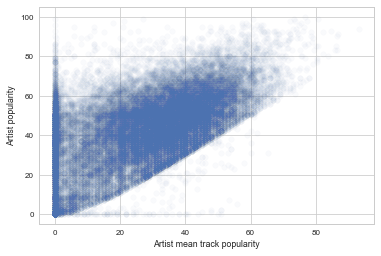

In [29]:
plt.scatter(temp['art_mean_trkpop'], temp['art_pop'], alpha = 0.03)
plt.xlabel("Artist mean track popularity")
plt.ylabel("Artist popularity")

# Playlist-level dataset build

In [6]:
# Make a playlist data subset as we'll use this often for EDA.  

df_pl_columns = ['pl_id', 'pl_days_old', 
                 'pl_days_active', 'pl_num_trk', 'pl_num_art', 
                 'pl_min_trkpop', 'pl_max_trkpop', 'pl_mean_trkpop', 
                 'pl_followers', 'pl_num_trks','pl_desc_chars'] 

df_pl = df_trk.groupby('pl_id').first().reset_index()[df_pl_columns]

print(df_pl.dtypes)
df_pl.head(10)

pl_id              object
pl_days_old       float64
pl_days_active    float64
pl_num_trk          int64
pl_num_art          int64
pl_min_trkpop     float64
pl_max_trkpop     float64
pl_mean_trkpop    float64
pl_followers        int32
pl_num_trks         int64
pl_desc_chars       int32
dtype: object


,pl_id,pl_days_old,pl_days_active,pl_num_trk,pl_num_art,pl_min_trkpop,pl_max_trkpop,pl_mean_trkpop,pl_followers,pl_num_trks,pl_desc_chars
0,002LPUZEpvopnQuRsxLjyV,"1,043.0000",0.0000,42,38,0.0000,69.0000,18.0714,2,42,0
1,009Uzz7eRh7QAIoeAKd0XN,740.0000,0.0000,26,25,0.0000,61.0000,21.6154,5514,26,13
2,00e2vXzWaSmxJ1Fga6l2ug,40.0000,34.0000,100,68,1.0000,83.0000,49.5200,209486,144,92
3,00tBWkHg7g57IiIaqkTeYa,"1,143.0000",130.0000,70,51,0.0000,73.0000,40.2286,5,70,0
4,01RvEaL25Hr46erZckIOlp,"1,672.0000","1,212.0000",100,38,0.0000,80.0000,42.5700,8,132,0
5,01RxbAsOSE0Aul4EKZQmN8,510.0000,326.0000,11,5,2.0000,41.0000,17.9091,8,11,0
6,01ZJ1fP7U7BwFoMUalCMl3,819.0000,66.0000,100,28,0.0000,70.0000,35.5000,4,101,0
7,01ce8cS6l2s280pGIOZBQU,165.0000,3.0000,100,72,12.0000,85.0000,61.6900,6,100,0
8,01omoXtdppulQ4w7zn7R3Q,"1,201.0000",0.0000,15,2,0.0000,0.0000,0.0000,344,15,0
9,01rjgzyfJG0tsaZZDctx6z,566.0000,529.0000,100,35,0.0000,78.0000,52.8800,243,138,0


# Now let's get our EDA ON BABY

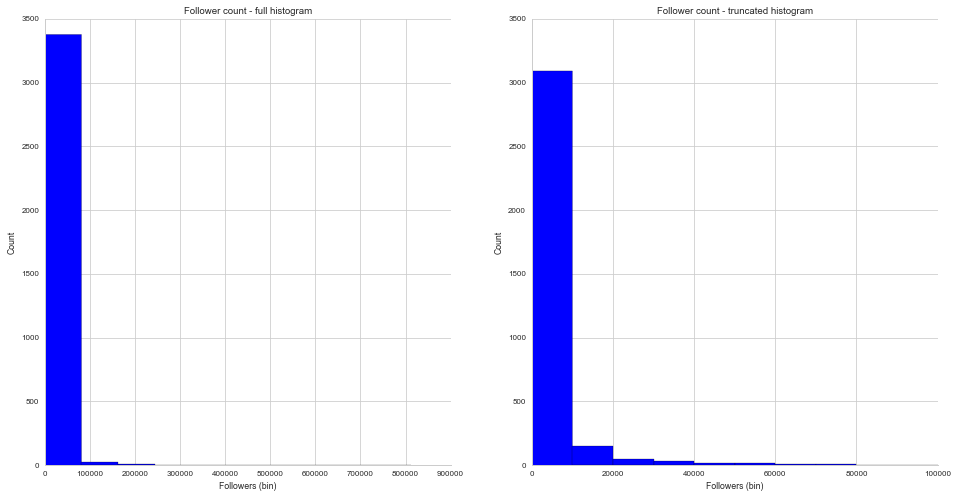

In [7]:
# Plot histogram of follower counts for each playlist
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].hist(df_pl.pl_followers)
ax[0].set_title("Follower count - full histogram")
ax[0].set_xlabel("Followers (bin)")
ax[0].set_ylabel("Count")
sns.despine()

ax[1].hist(df_pl.pl_followers, range = (0,100000))
ax[1].set_title("Follower count - truncated histogram")
ax[1].set_xlabel("Followers (bin)")
ax[1].set_ylabel("Count")
sns.despine(top = True, right = True)

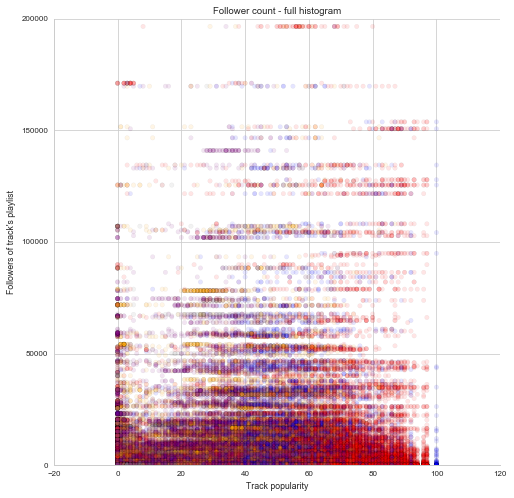

In [8]:
# Plot follower count vs. average track popularity
fig, ax = plt.subplots(1,1, figsize = (8,8))

colors = {'superstar':'red', 'star':'orange', 'crap_factory':'grey', 'one_hit_wonder':'blue', 'garage_band':'purple'}

ax.scatter(df_trk['trk_popularity'], df_trk['pl_followers'], alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax.set_title("Follower count - full histogram")
ax.set_xlabel("Track popularity")
ax.set_ylabel("Followers of track's playlist")
ax.set_ylim((0,200000))
sns.despine(top = True, right = True)

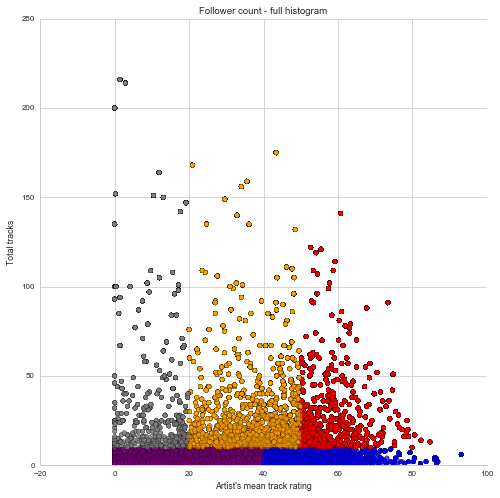

In [9]:
# Plot follower count vs. average track popularity
fig, ax = plt.subplots(1,1, figsize = (8,8))

colors = {'superstar':'red', 'star':'orange', 'crap_factory':'grey', 'one_hit_wonder':'blue', 'garage_band':'purple'}

ax.scatter(df_trk.art_mean_trkpop, df_trk.art_total_trks, alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax.set_title("Follower count - full histogram")
ax.set_xlabel("Artist's mean track rating")
ax.set_ylabel("Total tracks")
plt.ylim((0,250))
sns.despine(top = True, right = True)

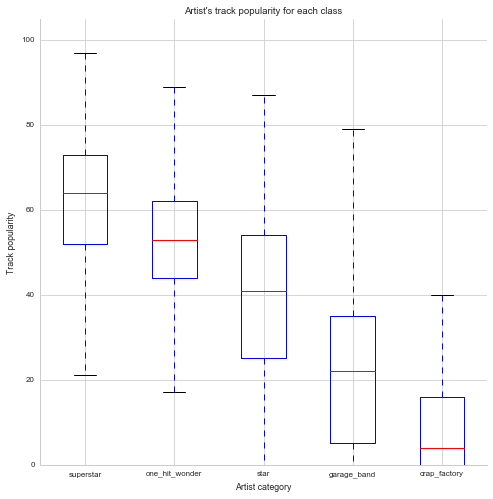

In [10]:
# Plot follower count vs. average track popularity
fig, ax = plt.subplots(1,1, figsize = (8,8))

labels = ['superstar', 'one_hit_wonder', 'star', 'garage_band', 'crap_factory']

ax.boxplot([df_trk[df_trk.art_class == 'superstar'].trk_popularity.values,
            df_trk[df_trk.art_class == 'one_hit_wonder'].trk_popularity.values,
            df_trk[df_trk.art_class == 'star'].trk_popularity.values,
            df_trk[df_trk.art_class == 'garage_band'].trk_popularity.values,
            df_trk[df_trk.art_class == 'crap_factory'].trk_popularity.values], labels = labels)
ax.set_title("Artist's track popularity for each class")
ax.set_xlabel("Artist category")
ax.set_ylabel("Track popularity")
ax.set_ylim((-0.1, 105))
sns.despine(top = True, right = True)

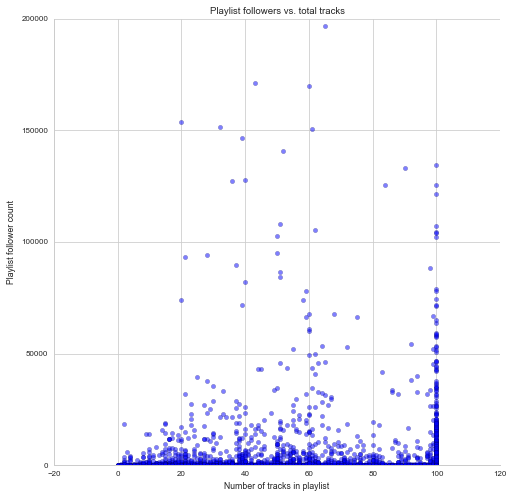

In [11]:
# Test if bigger playlists have more followers
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(df_pl.pl_num_trk, df_pl.pl_followers, alpha = 0.5)
ax.set_title("Playlist followers vs. total tracks")
ax.set_xlabel("Number of tracks in playlist")
ax.set_ylabel("Playlist follower count")
ax.set_ylim((0,200000))
sns.despine(top = True, right = True)

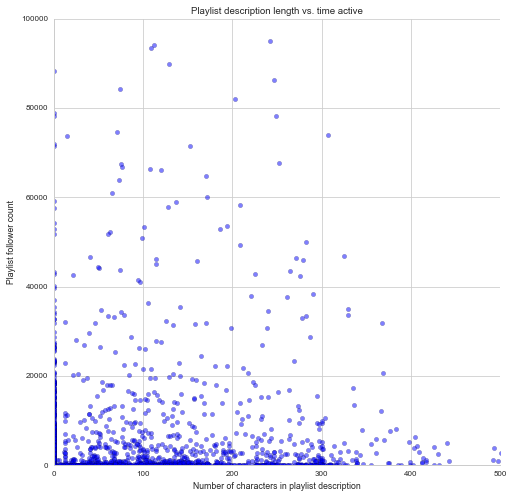

In [12]:
# Test if playlists with longer descriptions have more followers
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(df_pl.pl_desc_chars, df_pl.pl_followers, alpha = 0.5)
ax.set_title("Playlist description length vs. time active")
ax.set_xlabel("Number of characters in playlist description")
ax.set_ylabel("Playlist follower count")
ax.set_ylim((0,100000))
ax.set_xlim((0,500))
sns.despine(top = True, right = True)

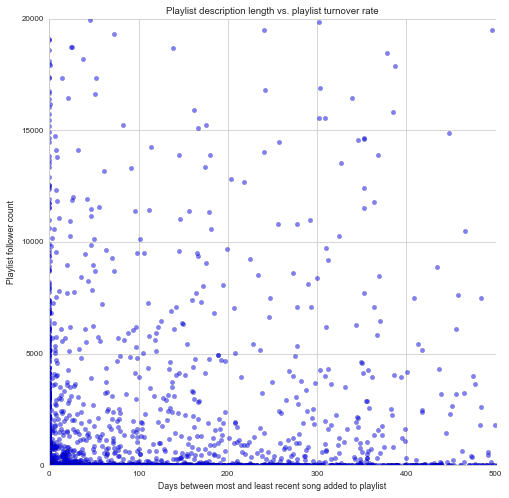

In [13]:
# Test if playlists with longer activity have more followers
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(df_pl.pl_days_active, df_pl.pl_followers, alpha = 0.5)
ax.set_title("Playlist description length vs. playlist turnover rate")
ax.set_xlabel("Days between most and least recent song added to playlist")
ax.set_ylabel("Playlist follower count")
ax.set_ylim((0,20000))
ax.set_xlim((0,500))
sns.despine(top = True, right = True)

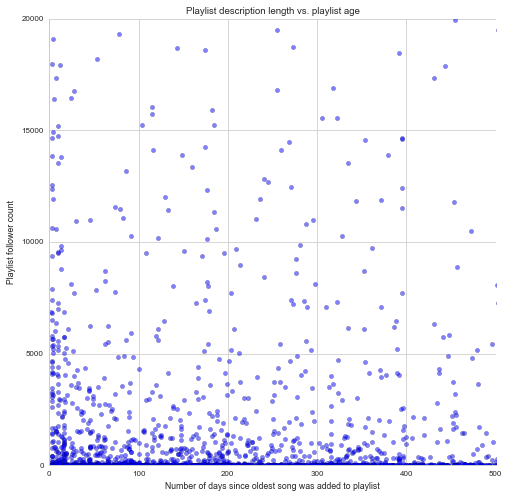

In [14]:
# Test if playlists with longer activity have more followers
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(df_pl.pl_days_old, df_pl.pl_followers, alpha = 0.5)
ax.set_title("Playlist description length vs. playlist age")
ax.set_xlabel("Number of days since oldest song was added to playlist")
ax.set_ylabel("Playlist follower count")
ax.set_ylim((0,20000))
ax.set_xlim((0,500))
sns.despine(top = True, right = True)

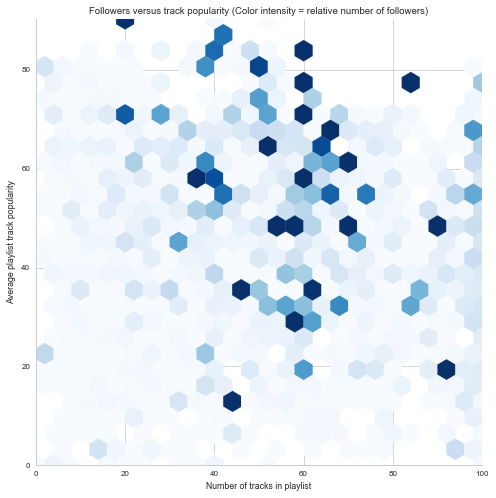

In [15]:
# Test playlist mean/max popularity versus follower count
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.hexbin(df_pl.pl_num_trk, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 25, vmax=35000)
ax.set_title("Followers versus track popularity (Color intensity = relative number of followers)")
ax.set_xlabel("Number of tracks in playlist")
ax.set_ylabel("Average playlist track popularity")
sns.despine(top = True, right = True)

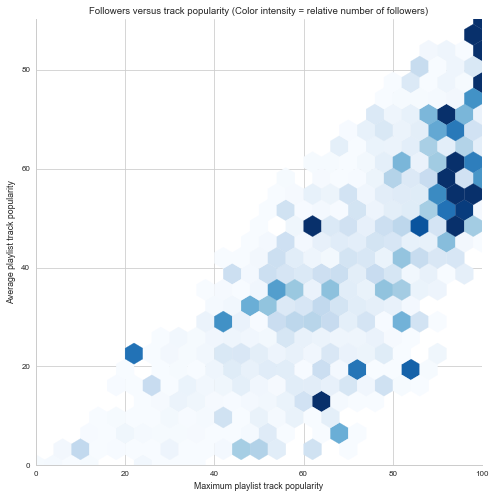

In [16]:
# Test playlist mean/max popularity versus follower count
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.hexbin(df_pl.pl_max_trkpop, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 25, vmax=25000)
ax.set_title("Followers versus track popularity (Color intensity = relative number of followers)")
ax.set_xlabel("Maximum playlist track popularity")
ax.set_ylabel("Average playlist track popularity")
sns.despine(top = True, right = True)

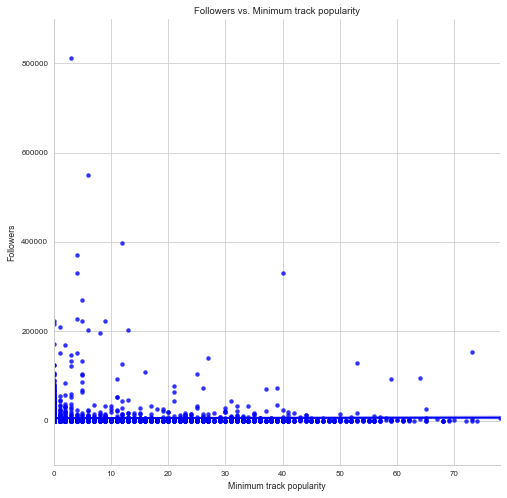

In [17]:
# Test association between followers vs. min track popularity.
sns.set_context('paper')
fig, ax = plt.subplots(1,1, figsize = (8,8))
sns.regplot('pl_min_trkpop', 'pl_followers', data=df_pl)
plt.xlim((0, max(df_pl.pl_min_trkpop)))
sns.despine()
plt.xlabel('Minimum track popularity')
plt.ylabel('Followers')
plt.title('Followers vs. Minimum track popularity')

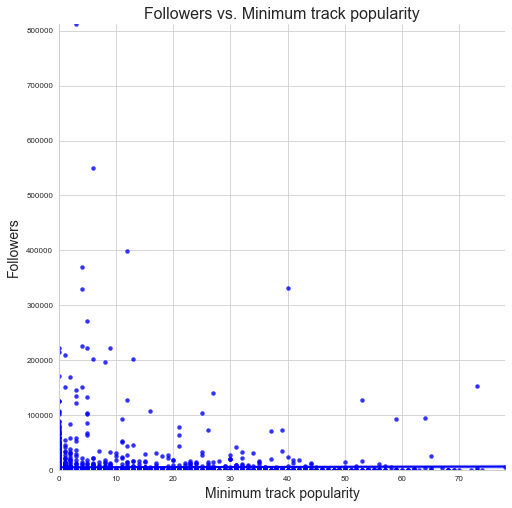

In [18]:
# Do playlists with a higher minimum track popularity attract more followers?

fig, ax = plt.subplots(figsize = (8,8))
ax.set_xlim((0, max(df_pl.pl_min_trkpop)))
ax.set_ylim((0, max(df_pl.pl_followers)))
sns.regplot('pl_min_trkpop', 'pl_followers', data=df_pl)
ax.set_title('Followers vs. Minimum track popularity', size=16)
ax.set_xlabel('Minimum track popularity', size=14)
ax.set_ylabel('Followers', size=14)
sns.despine()

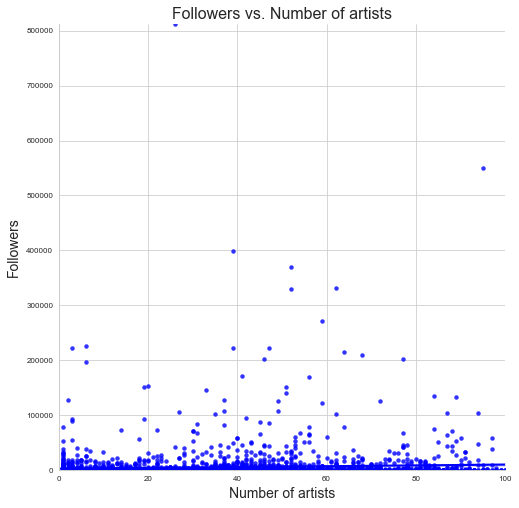

In [19]:
# Do playlists containing a greater number of artists attract more followers?

fig, ax = plt.subplots(figsize = (8,8))
ax.set_xlim((0, max(df_pl.pl_num_art)))
ax.set_ylim((0, max(df_pl.pl_followers)))
sns.regplot('pl_num_art', 'pl_followers', data=df_pl)
ax.set_title('Followers vs. Number of artists', size=16)
ax.set_xlabel('Number of artists', size=14)
ax.set_ylabel('Followers', size=14)
sns.despine()

# Let's get rrrrready to model!

Let's run some basic OLS regressions just to get a *rough* feel for the explanatory power of our current variables (no train, no test, just a little light play).

For the first OLS, let's use `statsmodels` instead of `sklearn` because it provides $p$-values for free to give us a ballpark idea of statistical significance. This could give us insight over what other data source(s) may be the most promising as supplements to our current data.

In [20]:
#####################################################################
# Common call to fit OLS model using statsmodels.api.
#####################################################################

def fit_ols (df, x, y, min_obs=2000, intcp=1, dropna=True):
    """Fits statsmodels.api.OLS and returns RegressionResults object.
    
    Args:
        df (DataFrame): Contains data with which to train the model.
        x (str or List[str]): Names of predictor columns in df.
        y (str): Name of response column in df.
        min_obs (int): Minimum observations from df from which to train OLS
            model.
        intcp (float): Model intercept.
        dropna (bool): If True, all rows where any or all of the data are
            missing from the x- or y-var are dropped before creating model.

    Raises:
        RuntimeError if
        *   df empty after dropping NAs.
        *   Final number of observations used to fit model is less than min_obs.

    Returns:
        model (RegressionResults): Result from fitting OLS model.
    """
    # Remove rows containing NAs.
    xvar, yvar, params = __create_params_list(x, y)
    df = df[params].copy(deep=True)
    if dropna:
        df.dropna(how='any', inplace=True)

    if len(df.index) == 0:
        raise RuntimeError('fit_ols training df empty after dropping NA.')

    # Extract X & Y variables.
    X = df[xvar]
    X['intercept'] = intcp
    Y = df[yvar]

    try:
        model = sm.OLS(Y, X).fit()
    except:
        raise RuntimeError('Fitting model: sm.OLS(Y, X).fit()')

    # Raise error if number of observations used in creating model doesn't
    # meet minimum.
    if model.nobs < min_obs:
        raise RuntimeError('fit_ols insufficient obs: {0}.'.format(
              int(model.nobs)))
    return model

def __create_params_list (x, y):
    """Returns 3-tuple consisting of (x-vars, y-var, x + y-vars list) where
    each element of the tuple is a list.
    """
    if isinstance(x, str):
        x_var = [x]
    else:
        x_var = x
    if isinstance(y, str):
        y_var = [y]
    else:
        y_var = y

    try:
        params = x_var + y_var
    except TypeError:
        params = list(x)
        params.append(y)
    return x_var, y_var, params

In [21]:
# Regress followers against all x-variables in our playlist DF.

xvars = ['pl_num_trks', 'pl_days_active', 'pl_days_old', 'pl_num_trk', 'pl_num_art', 
         'pl_min_trkpop', 'pl_max_trkpop', 'pl_mean_trkpop', 'pl_desc_chars']
yvar = 'pl_followers'
ols_v1 = fit_ols(df_pl, xvars, yvar)
ols_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           pl_followers   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     12.17
Date:                Tue, 28 Nov 2017   Prob (F-statistic):           3.91e-19
Time:                        01:49:35   Log-Likelihood:                -39747.
No. Observations:                3420   AIC:                         7.951e+04
Df Residuals:                    3410   BIC:                         7.958e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
pl_num_trks        1.9904      1.341      1.484      0.138      -0.639       4.620
pl_days_active     2.5886      1.410      1.836      0.066      -0.175       5.352
pl_days_old       -0.7222      1.071     -0.674      0.500      -2.822       1.377
pl_num_trk        10.2051     21.082      0.484      0.628     -31.130      51.540
pl_num_art        15.2406     27.581      0.553      0.581     -38.837      69.318
pl_min_trkpop    -32.1148     43.646     -0.736      0.462    -117.689      53.460
pl_max_trkpop     58.5927     52.611      1.114      0.265     -44.560     161.745
pl_mean_trkpop   113.1228     60.444      1.872      0.061      -5.387     231.632
pl_desc_chars     36.0494      5.179      6.960      0.000      25.894      46.204
intercept      -6631.2591   2359.433     -2.811      0.005   -1.13e+04   -2005.212
==============================================================================
Omnibus:                     6553.238   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14614007.734
Skew:                          14.614   Prob(JB):                         0.00
Kurtosis:                     321.905   Cond. No.                     5.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Look at just the coefficients and p-values of our first model: which are 
# most statistically significant? (put them in a DataFrame for easy sort)

df_pvals_v1 = pd.concat((ols_v1.params, ols_v1.pvalues), axis=1)
df_pvals_v1.columns = ['beta', 'pval']
df_pvals_v1.sort_values(by='pval', ascending=True, inplace=True)
df_pvals_v1

,beta,pval
pl_desc_chars,36.0494,0.0000
intercept,"-6,631.2591",0.0050
pl_mean_trkpop,113.1228,0.0614
pl_days_active,2.5886,0.0664
pl_num_trks,1.9904,0.1379
pl_max_trkpop,58.5927,0.2655
pl_min_trkpop,-32.1148,0.4619
pl_days_old,-0.7222,0.5001
pl_num_art,15.2406,0.5806
pl_num_trk,10.2051,0.6284


## Data transformations?

We saw earlier on in this notebook that the response (`pl_followers`) is severely right-skewed (i.e, clustered at lower numbers of playlist followers). This could be a problem for our models.

**What's one way we can potentially remedy right-skewedness? => Log-transform**

Let's try it out. You'll see below that the $R^2$ goes up significantly when we regress the log of `pl_followers` against the prior set of $x$-variables.

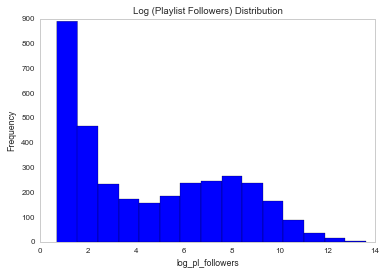

In [23]:
def plot_hist (x, title=None, xlabel=None, ylabel=None, bins=10, normed=False,
               align='mid', add_best_fit=False, grid=False):
    """Displays histogram."""
    n, bins, patches = plt.hist(x, bins=bins, normed=normed, align=align)
    if add_best_fit:
        mu = np.mean(x)
        sigma = np.std(x)
        y = mlab.normpdf(bins, mu, sigma)
        # If not plotting probability density, then multiply normal pdf for values
        # by mu so scale makes sense w/ x (yet shape is preserved).
        if not normed:
            y = y * mu
        plt.plot(bins, y, 'r--', linewidth=1)

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.grid(grid)
    plt.show()


# Log the response variable in DataFrame.
df_pl['log_pl_followers'] = np.log(df_pl['pl_followers'])

# What does the distribution of our response look like now?
# Should be more normal.
plot_hist(df_pl['log_pl_followers'], 
          title='Log (Playlist Followers) Distribution',
          bins=15,
          xlabel='log_pl_followers',
          ylabel='Frequency')

In [24]:
# Now fit new OLS using log(response) as the new response.
ols_v2 = fit_ols(df_pl, xvars, 'log_pl_followers')
ols_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_pl_followers   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     63.82
Date:                Tue, 28 Nov 2017   Prob (F-statistic):          1.10e-108
Time:                        01:49:35   Log-Likelihood:                -8649.2
No. Observations:                3420   AIC:                         1.732e+04
Df Residuals:                    3410   BIC:                         1.738e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
pl_num_trks        0.0004      0.000      2.527      0.012    8.54e-05       0.001
pl_days_active     0.0007      0.000      4.229      0.000       0.000       0.001
pl_days_old       -0.0005      0.000     -4.177      0.000      -0.001      -0.000
pl_num_trk         0.0095      0.002      4.012      0.000       0.005       0.014
pl_num_art         0.0021      0.003      0.663      0.508      -0.004       0.008
pl_min_trkpop      0.0089      0.005      1.823      0.068      -0.001       0.019
pl_max_trkpop      0.0041      0.006      0.686      0.493      -0.008       0.016
pl_mean_trkpop     0.0091      0.007      1.341      0.180      -0.004       0.022
pl_desc_chars      0.0106      0.001     18.271      0.000       0.009       0.012
intercept          2.7210      0.265     10.255      0.000       2.201       3.241
==============================================================================
Omnibus:                      724.827   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.771
Skew:                           0.423   Prob(JB):                     1.73e-51
Kurtosis:                       2.038   Cond. No.                     5.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# Let's have a look at these updated p-values.
df_pvals_v2 = pd.concat((ols_v2.params, ols_v2.pvalues), axis=1)
df_pvals_v2.columns = ['beta', 'pval']
df_pvals_v2.sort_values(by='pval', ascending=True, inplace=True)
df_pvals_v2

,beta,pval
pl_desc_chars,0.0106,0.0000
intercept,2.7210,0.0000
pl_days_active,0.0007,0.0000
pl_days_old,-0.0005,0.0000
pl_num_trk,0.0095,0.0001
pl_num_trks,0.0004,0.0115
pl_min_trkpop,0.0089,0.0683
pl_mean_trkpop,0.0091,0.1801
pl_max_trkpop,0.0041,0.4929
pl_num_art,0.0021,0.5076
